## WOE 
---

In [1]:
import sys, os, pathlib
sys.path.insert(1, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ml4risk.data_preparation.woe import WOE_Transform

%load_ext autoreload
%autoreload 2

### Load data and process features

In [ ]:
features = pd.read_csv("simple-feature-importance.csv")

meta_cols = ['TARGET','SK_ID_CURR','index']
top_features = features.groupby("feature")["importance"].mean().sort_values(ascending=False).head(30)
top_features = top_features.index.to_list()

In [35]:
train_df = pd.read_parquet("../../data/home-credit-default-risk/train_df.parquet",
                           columns=meta_cols+top_features)

### Transform woe to sklearn style class

In [50]:
min_bin_size = int(train_df.shape[0] * 0.05)  # use this to ensure each bin contains at least 5% 
min_bin_size

15375

In [51]:
woe = WOE_Transform(min_samples_leaf=min_bin_size, min_iv=-np.inf)
woe.fit(train_df[top_features], train_df["TARGET"], display=-1)
woe_df = woe.transform(train_df[top_features])

/home/ec2-user/anaconda3/envs/ml4risk/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ec2-user/anaconda3/envs/ml4risk/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ec2-user/anaconda3/envs/ml4risk/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ec2-user/anaconda3/envs/ml4risk/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


processed  30  num attributes

transformed num 20



/home/ec2-user/anaconda3/envs/ml4risk/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
train_df = train_df.merge(woe_df, how='inner', left_index=True, right_index=True)
features_woe = woe_df.columns.to_list()

In [53]:
import math
import matplotlib.pyplot as plt
    
def plot_woe(fname, woe_dict, ax=None):
    if ax is None:
        fig = plt.figure()
    x = woe_dict[fname]["min"]
    y = woe_dict[fname]["woe"]
    ax.plot(x, y)
    ax.set_title(f"{fname}")
    
def get_woe_plots(df, woe_dict, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        plot_woe(feature, woe_dict, ax=ax)        
    return fig

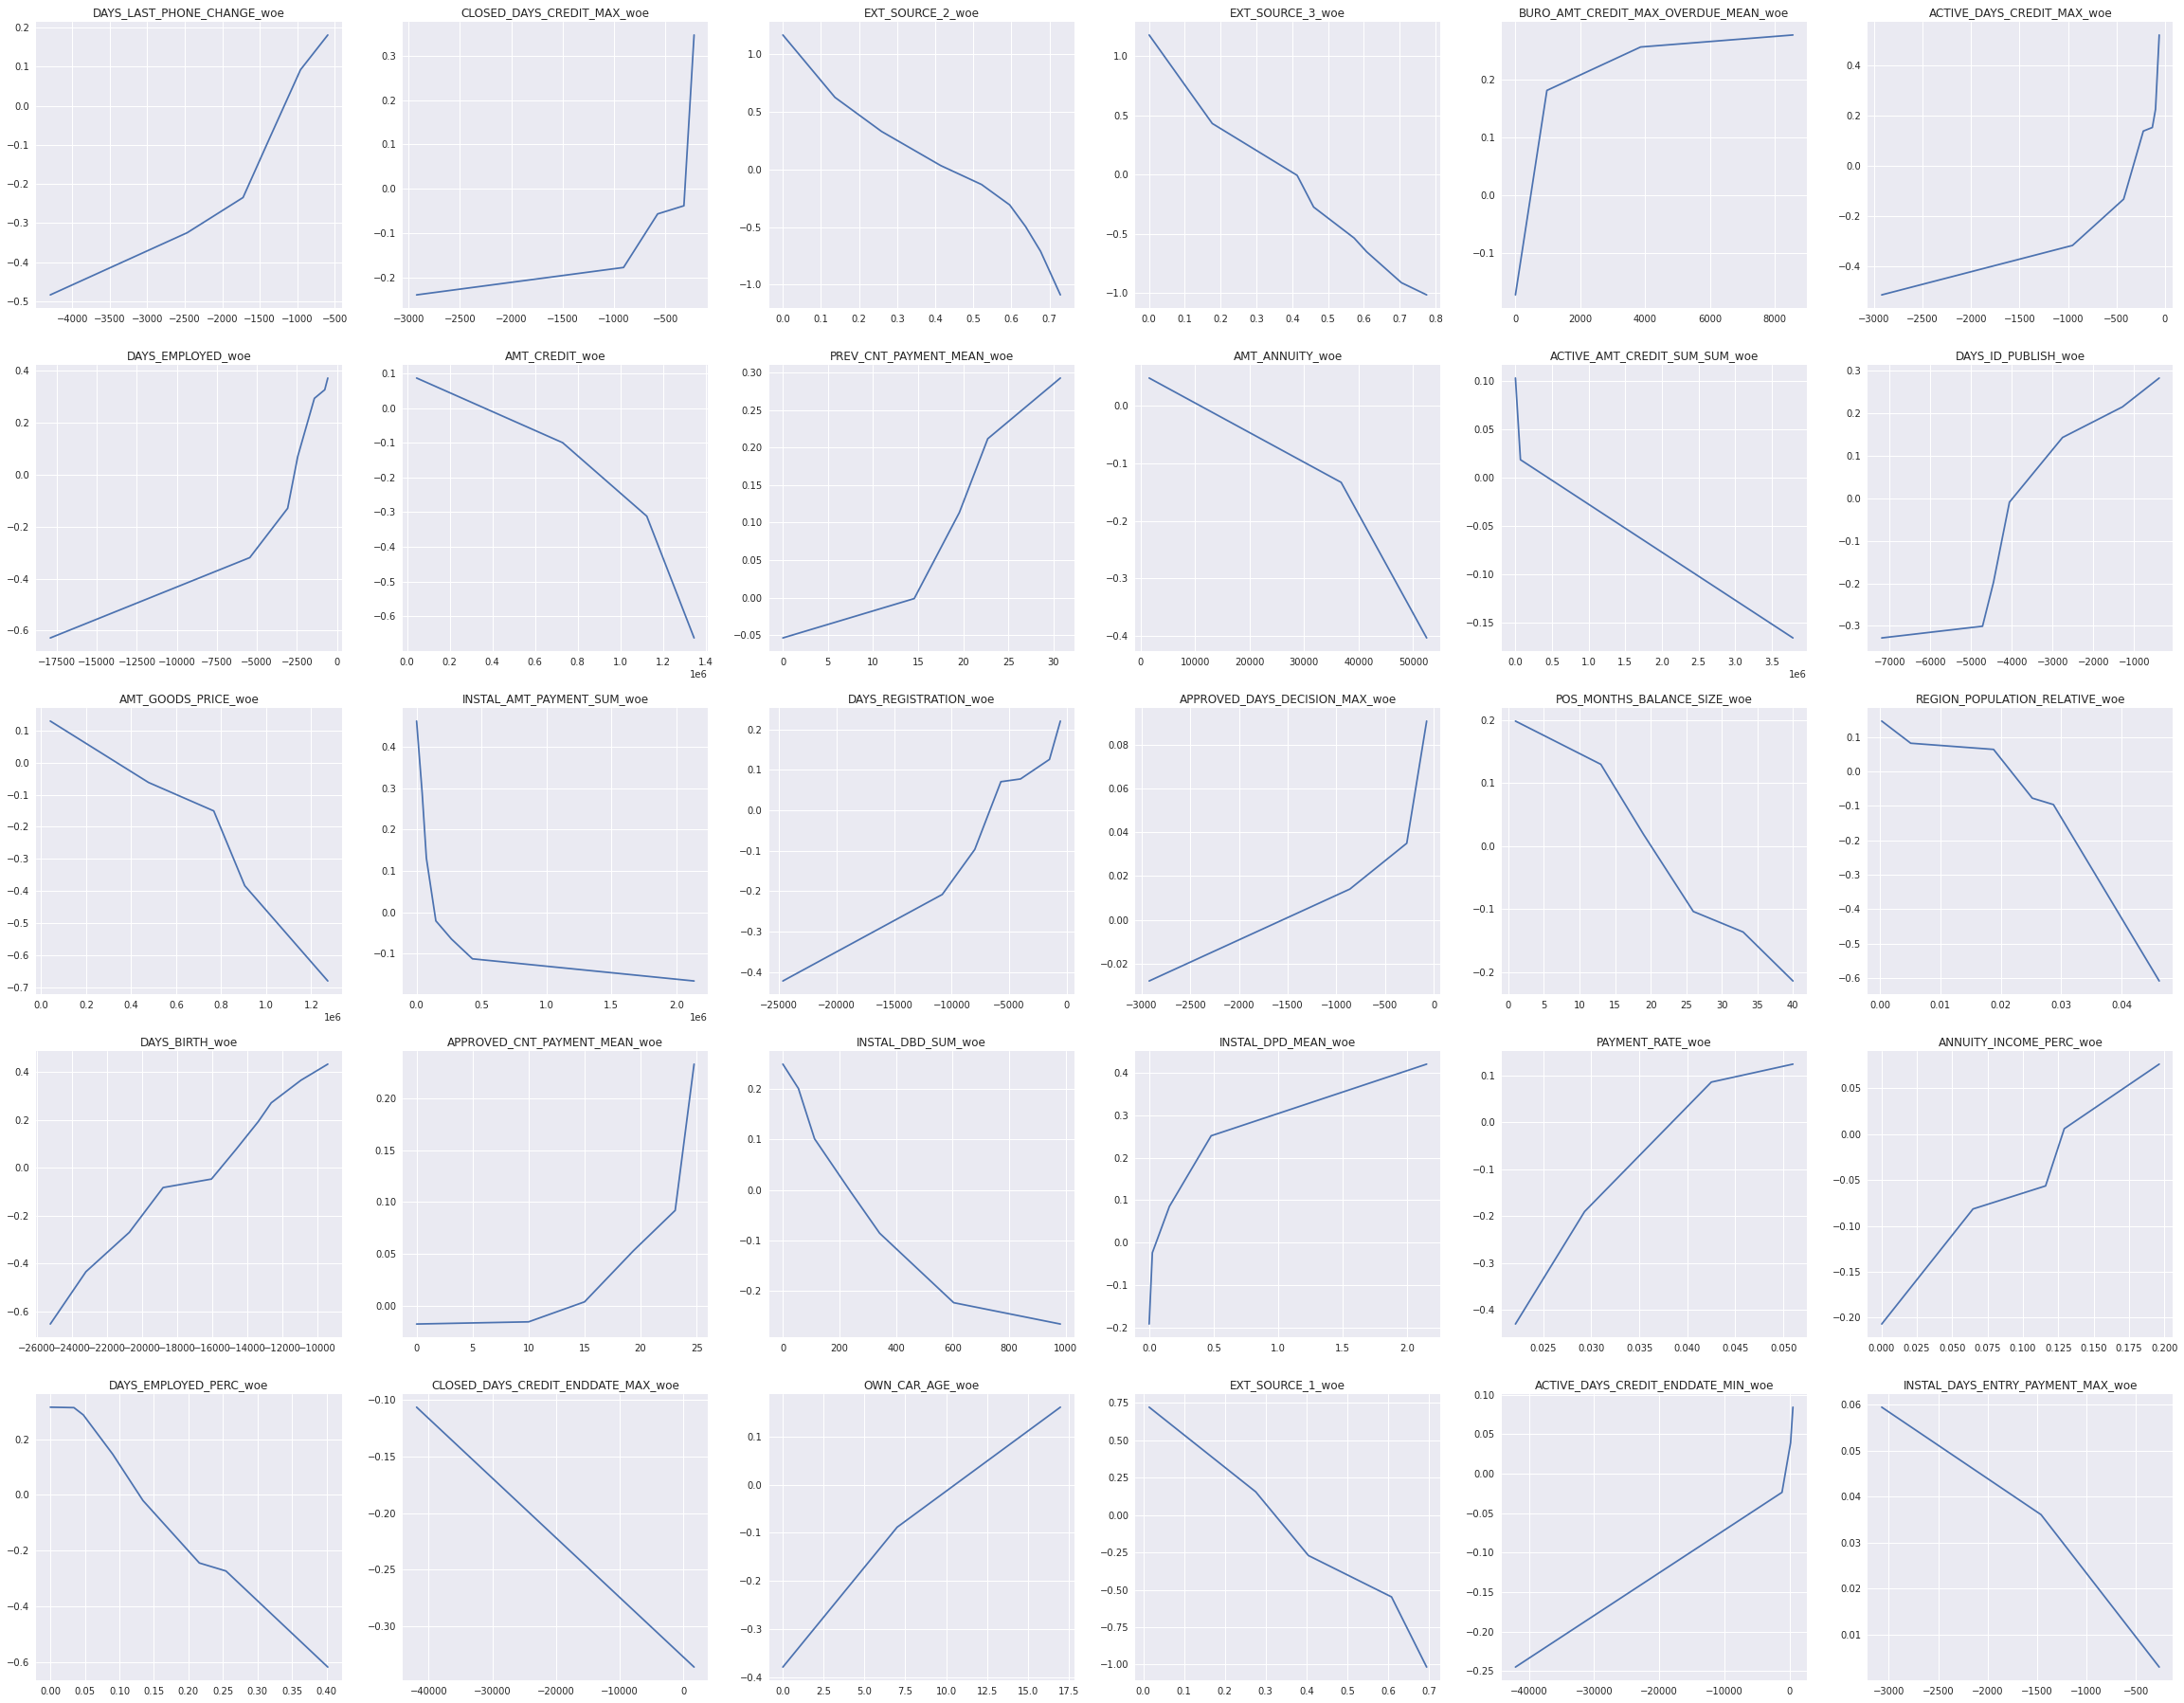

In [56]:
plt.style.use("seaborn")
woe_dict = woe.woe_dict()
woe_dict = dict([(k+"_woe", v) for k,v in woe_dict.items()])
fig = get_woe_plots(train_df, woe_dict, features_woe)

In [75]:
woe.woe_dict()[ft]

,%accts,min,max,woe
0,41.09%,0.000,9.701662e+02,-0.1727
1,8.03%,970.200,3.861180e+03,0.1814
2,5.64%,3861.783,8.558085e+03,0.2566
3,5.04%,8558.505,1.159872e+08,0.2774
missing,40.20%,NaN,NaN,0.0451
